In [69]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

In [22]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("dataset.tsv", sep='\t', header=None, names = column)
df.size

1896186

In [23]:
# Selecting only 0.05 < z < 0.08 and spiral (late-type!) (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50)]
print("Dataframe size post-cut:",df.size)
df = df.sample(n=10000)

Dataframe size post-cut: 431832


In [5]:
max(df['uMAG'])

-10.514

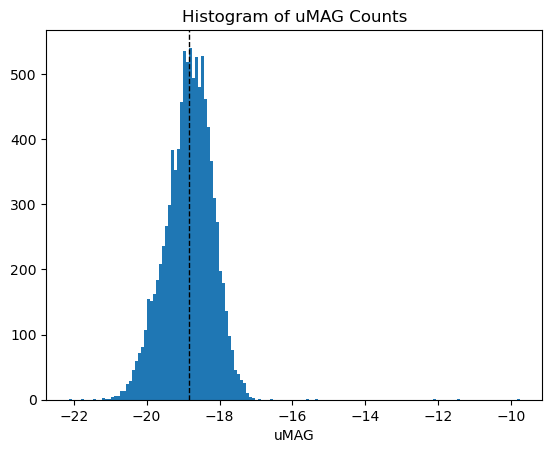

-19.713881 -18.05296


In [43]:
plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")
plt.show()
print(np.percentile(df['uMAG'],10),np.percentile(df['uMAG'],90)) # Find the censor range for later

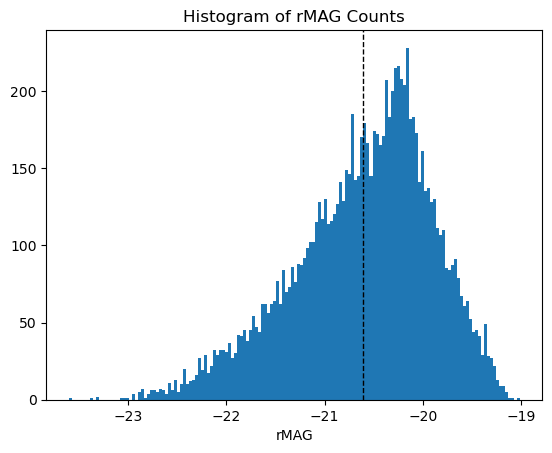

In [9]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")
plt.show()

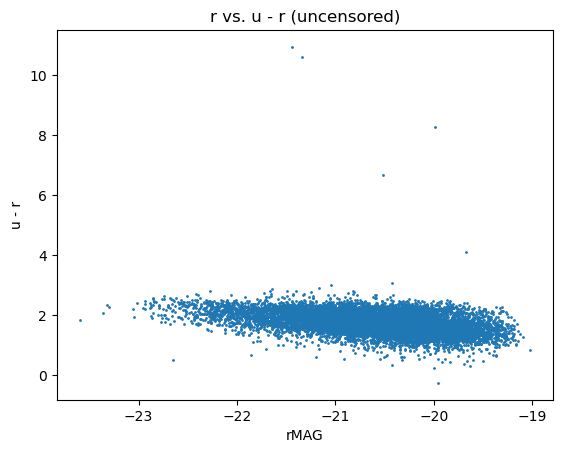

In [10]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (uncensored)")
plt.show()

In [54]:
# Adding censored data column for -19.7 < uMAG < -18
print(len(df[df["uMAG"]>-18.4])) 
df['censored_uMAG'] = df['uMAG'].clip(upper=-18,lower=-19.7) # Made the censoring code a little prettier
censored_array=np.array([])
for i in np.array(df["uMAG"]): # This code is ugly - does pandas have a way to do this itself?
    if (i<-18 and i>-19.7):
        censored_array=np.append(censored_array,False)
    else:
        censored_array=np.append(censored_array,True)
df['censored']=censored_array
df.head()
#df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17 (Old code)

2561


,objID,z,uMAG,rMAG,u-r,SVMPython,censored_uMAG,censored_u-r,censored
112914,1237657222561857647,0.071423,-19.30886,-21.10671,1.79785,1,-19.30886,1.79785,0.0
216710,1237662224077553865,0.067581,-20.15594,-21.87293,1.71700,1,-19.70000,2.17293,1.0
291459,1237662698652631319,0.060993,-18.45701,-19.87865,1.42164,1,-18.45701,1.42164,0.0
186509,1237664846122320036,0.068404,-19.42295,-21.60828,2.18533,1,-19.42295,2.18533,0.0
38096,1237654385195286649,0.051837,-18.00433,-19.56672,1.56239,1,-18.00433,1.56239,0.0


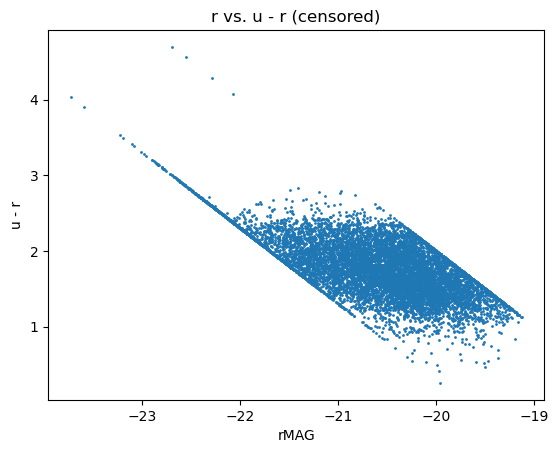

In [46]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (censored)")
plt.show()

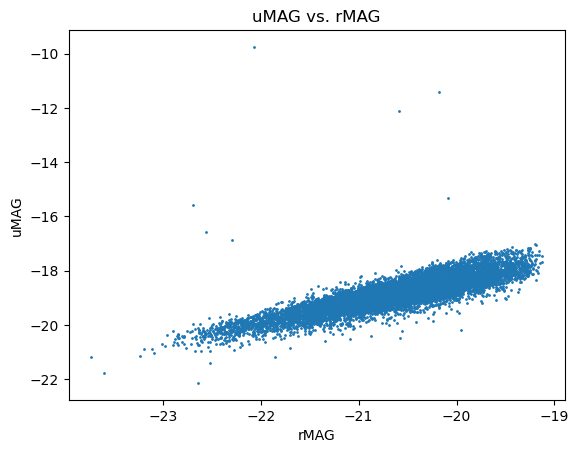

In [40]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG')
plt.show()

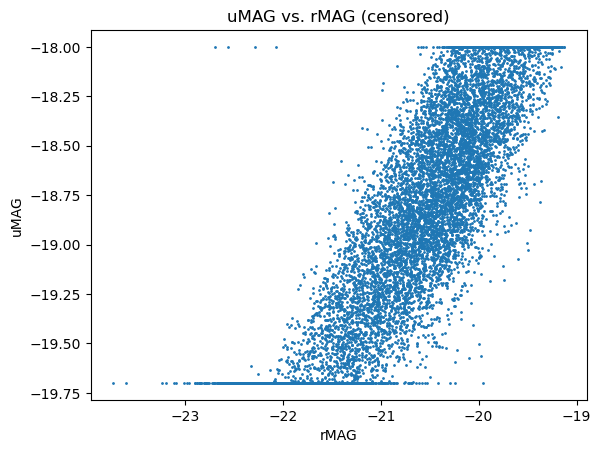

In [48]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')
plt.show()

## r vs u-r (not censored)

In [62]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=sigma, observed=y)
    return model

In [63]:
q1_model = lregression(df['rMAG'], df['u-r'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = 5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 105 seconds.


array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

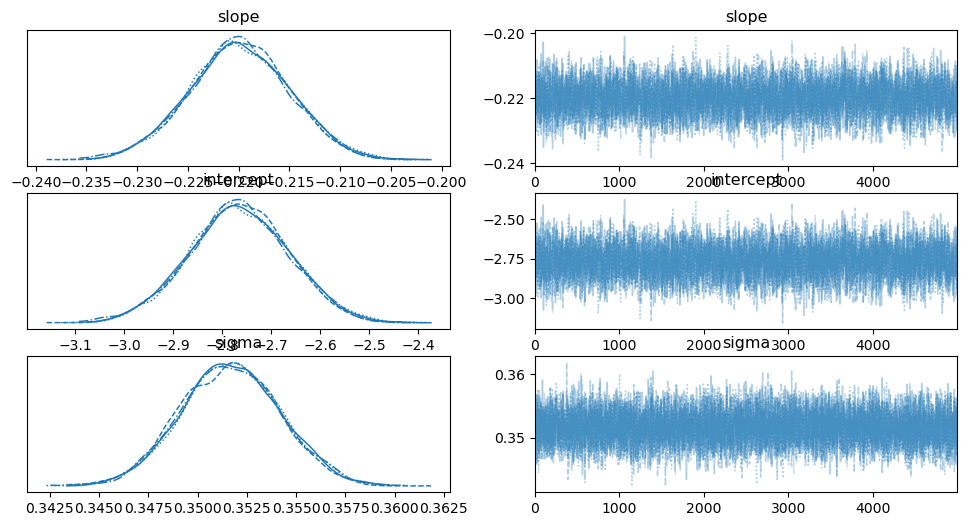

In [64]:
az.plot_trace(q1_fit)

In [65]:
summ=az.summary(q1_fit)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.220,0.005,-0.229,-0.210,0.000,0.000,5470.0,6497.0,1.0
intercept,-2.766,0.102,-2.959,-2.575,0.001,0.001,5455.0,6483.0,1.0
sigma,0.352,0.003,0.347,0.356,0.000,0.000,8915.0,8634.0,1.0


[Text(0.5, 1.0, 'r vs u-r (uncensored data) fit'), None]

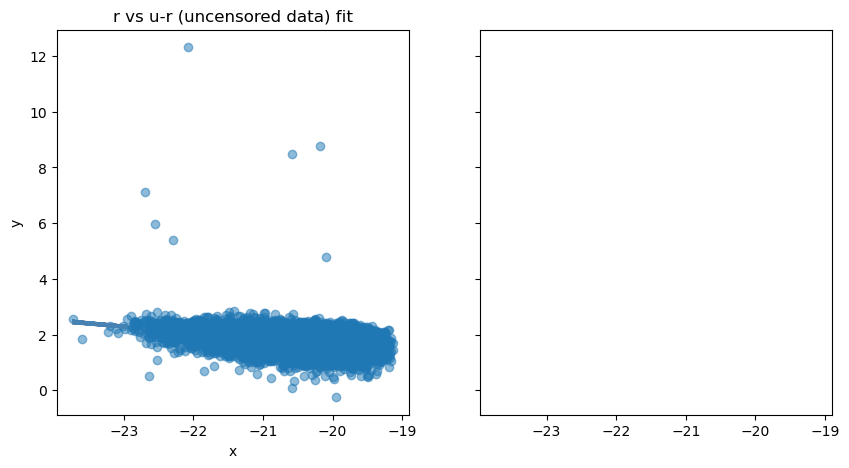

In [72]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="steelblue", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['u-r'], q1_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (uncensored data) fit",alpha=0.5)